In [190]:
import torch
import torch.nn.functional as F

import torchsde

import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

In [18]:
class Net(torch.nn.Module):

    def __init__(self, input_dim=1):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        # an affine operation: y = Wx + b
        self.input_dim = input_dim
        self.fc1 = torch.nn.Linear(input_dim, 120)  # 5*5 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, input_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [79]:
import torch

batch_size, state_size, brownian_size = 32, 3, 2
t_size = 20

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self, state_size=1, brownian_size=1, batch_size=10, γ=1.0):
        super().__init__()
        
        self.state_size = state_size
        self.brownian_size = brownian_size
        self.batch_size = batch_size

        self.γ = torch.tensor(γ)
        self.μ = Net(input_dim=state_size)
        self.σ = lambda x: torch.sqrt(self.γ) * torch.eye(self.state_size, self.brownian_size).repeat(batch_size,1)

    # Drift
    def f(self, t, y):
        return self.μ(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        σ = self.σ(y)
#         print(σ.shape, y.shape, self.brownian_size)
        return self.σ(y).view(self.batch_size, 
                              self.state_size, 
                              self.brownian_size)


# sde = SDE(state_size, brownian_size, batch_size, 1)
# y0 = torch.full((batch_size, state_size), 0.1)
# ts = torch.linspace(0, 1, t_size)
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
# ys = torchsde.sdeint(sde, y0, ts)

In [197]:
def log_g(Θ, ln_prior, ln_like, γ=1.0):
    """
    g function in control objective
    
    g is the Radon-Nikodym derivtive between
    the joint and N(0, γ I)
    """
    normal_term = -0.5 * (Θ**2).sum(axis=1) / γ
    return ln_prior(Θ) + ln_like(Θ) - normal_term

def log_likelihood(Θ, X, y):
    """
    Slow implementation of logistic log likleihood
    as a function of the parameters
    """
#     import pdb; pdb.set_trace()
    logits = X.mm(Θ.T)
    
    pos_weights = torch.ones(logits.shape[0]*logits.shape[1])
    loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction="sum")
    
    # Should reimplement BCEWithLogitsLoss with logsumexp from scratch
    # since this next line the .repeat is extremely inneficient
    vector_loss = loss(logits.reshape(-1), y.reshape(-1,1).repeat(1, logits.shape[1]).reshape(-1))

    return vector_loss / Θ.shape[0]

def log_likelihood_vmap(Θ, X, y):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
#     import pdb; pdb.set_trace()
    logits = X.mm(Θ.T)
    
    pos_weights = torch.ones(logits.shape[0])
    loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction="sum")
    
    loss_ = lambda x: loss(x, y)
    
    # Should reimplement BCEWithLogitsLoss with logsumexp from scratch
    # since this next line the .repeat is extremely inneficient
#     import pdb; pdb.set_trace()
    batched_loss =  torch._vmap_internals.vmap(loss_)
#     vector_loss = torch.vmap(loss_, logits).sum()
#     import pdb; pdb.set_trace()
    return batched_loss(logits.T).mean()

def gaussian_prior(Θ, σ_w=0.9):
    return -0.5 * (Θ**2).sum(axis=1) / σ_w

def relative_entropy_control_cost(sde, Θ_0, X, y, ln_prior, ln_like, Δt=0.05, γ=1.0):
    """
    Objective for the Hamilton-Bellman-Jacobi Follmer Sampler
    """
    n = int(1.0 / Δt)
    ts = torch.linspace(0, 1, n)
    
    ln_like_partial = lambda Θ: ln_like(Θ, X, y)
    
    Θs =  torchsde.sdeint(sde, Θ_0, ts)
    μs = sde.f(ts, Θs)
    ΘT = Θs[-1,:,:] 
    lng = log_g(ΘT, ln_prior, ln_like_partial, γ).mean()
    girsanov_factor = (0.5 / γ) * ((μs**2).sum(axis=-1)).mean()
    
    return girsanov_factor - lng

In [186]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']

# Binary classification
X = X[~(y==2)][:,[0,1]]
y = y[~(y==2)]

# dummy dims 
X = np.concatenate((torch.ones(X.shape[0],1), torch.tensor(X) ), axis=1)

names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = torch.tensor(X_train), torch.tensor(X_test), torch.tensor(y_train), torch.tensor(y_test) 

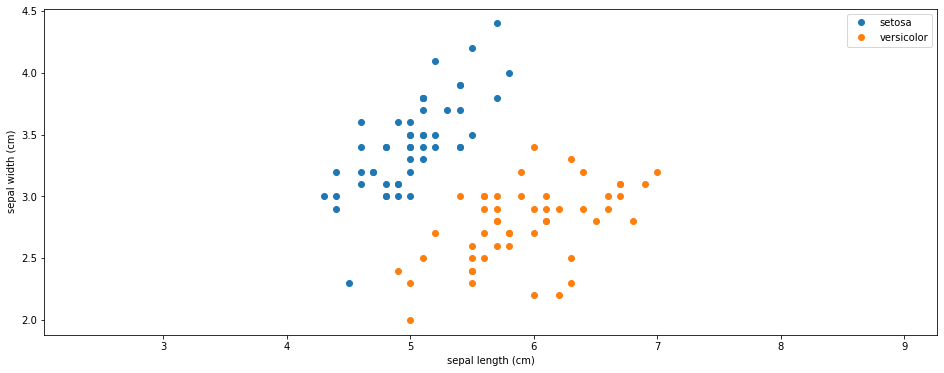

In [187]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
for target, target_name in enumerate(names[0:2]):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 1], X_plot[:, 2], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();


In [188]:
t_size = 20
dim = 3

no_posterior_samples = 50

sde = SDE(dim, dim, no_posterior_samples, 1.0)
Θ_0 = torch.full((no_posterior_samples, dim), 0.1) * 0 # Θ_0 ~ δ_0
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts)

In [198]:
relative_entropy_control_cost(sde, Θ_0.float(), X_train.float(), y_train.float(), gaussian_prior, log_likelihood_vmap)

tensor(-73.7113, grad_fn=<SubBackward0>)

In [199]:

γ = torch.tensor(1.5)

sde = SDE(dim, dim, no_posterior_samples  , γ=γ)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 100
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = relative_entropy_control_cost(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                gaussian_prior, log_likelihood, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = relative_entropy_control_cost(
            sde, Θ_0.float(),
            X_train.float(), y_train.float(),
            gaussian_prior, log_likelihood, γ=γ
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

<ipython-input-79-8900b35f9791>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.γ = torch.tensor(γ)


  0%|          | 0/100 [00:00<?, ?it/s]

In [200]:
losses

[-83.18810272216797,
 6462.490234375,
 -127.7713851928711,
 -67.90473175048828,
 -71.03211975097656,
 -93.39411163330078,
 -68.6809310913086,
 -112.74694061279297,
 -137.52447509765625,
 -199.534423828125,
 -258.6856689453125,
 -378.0881652832031,
 -561.1829833984375,
 -943.5221557617188,
 5830.51953125,
 -966.8297119140625,
 -593.740966796875,
 -382.625,
 -313.1337890625,
 -268.56842041015625,
 -239.6722412109375,
 -237.74913024902344,
 -172.4215545654297,
 -203.92576599121094,
 -180.6106719970703,
 -157.60659790039062,
 -165.9214630126953,
 -190.35824584960938,
 -192.28269958496094,
 -206.65426635742188,
 -232.9462127685547,
 -227.0182342529297,
 -284.8259582519531,
 -354.0434875488281,
 -509.5357971191406,
 -812.4512329101562,
 -1160.99609375,
 1449.9150390625,
 -1397.1025390625,
 -1116.606689453125,
 -882.0943603515625,
 -804.7872924804688,
 -860.0865478515625,
 -960.5713500976562,
 -1199.0892333984375,
 -1333.2081298828125,
 -1506.1768798828125,
 -1017.3701171875,
 -1439.706420898

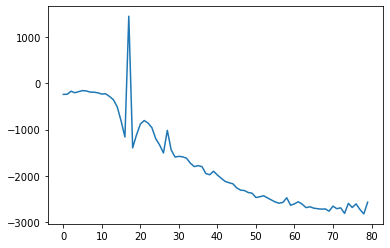

In [201]:
plt.plot(losses[20:])

In [202]:
 torchsde.sdeint(sde, Θ_0, ts).shape

torch.Size([20, 50, 3])

In [203]:
X_train.shape

torch.Size([80, 3])

In [204]:
Θ_1 = torchsde.sdeint(sde, Θ_0, ts)[-1,...]

(array([2., 3., 5., 8., 6., 5., 8., 5., 3., 5.]),
 array([38.43737 , 39.678345, 40.919315, 42.16029 , 43.401264, 44.642235,
        45.88321 , 47.124184, 48.365158, 49.60613 , 50.847103],
       dtype=float32),
 <a list of 10 Patch objects>)

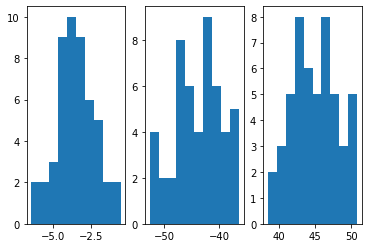

In [205]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].detach().numpy())
ax2.hist(Θ_1[:,1].detach().numpy())
ax3.hist(Θ_1[:,2].detach().numpy())

In [176]:
pred = torch.sigmoid(X_train.float().mm(Θ_1.T)).mean(axis=1)

In [177]:
((pred < 0.5).float() == y_train).float().mean()

tensor(0.9875)

In [178]:
pred_test = torch.sigmoid(X_test.float().mm(Θ_1.T)).mean(axis=1)

In [179]:
((pred_test < 0.5).float() == y_test).float().mean()

tensor(1.)

In [138]:
y_test, (pred_test < 0.5).long()

(tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1],
        dtype=torch.int32),
 tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]))

In [186]:
import numpy as np
import scipy.special as ssp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions.constraints as constraints

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD

pyro.enable_validation(True)
torch.set_default_dtype(torch.double) # this was necessary on the CPU

In [188]:

# these were adapted from the Pyro VAE tutorial

def train(svi, train_loader, n_train):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, xs in enumerate(train_loader):
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(*xs)

    # return epoch loss
    total_epoch_loss_train = epoch_loss / n_train
    return total_epoch_loss_train


def evaluate(svi, test_loader, n_test):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for _, xs in enumerate(test_loader):
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(*xs)

    total_epoch_loss_test = test_loss / n_test
    return total_epoch_loss_test


def plot_llk(train_elbo, test_elbo, test_int):
    plt.figure(figsize=(8, 6))

    x = np.arange(len(train_elbo))

    plt.plot(x, train_elbo, marker='o', label='Train ELBO')
    plt.plot(x[::test_int], test_elbo, marker='o', label='Test ELBO')
    plt.xlabel('Training Epoch')
    plt.legend()
    plt.show()

In [299]:
class LogRegressionModel(nn.Module):
    def __init__(self, p):
        super(LogRegressionModel, self).__init__()
        
        self.p = p

        # hyperparameters for normal priors
        self.alpha_h_loc = torch.zeros(1, p)
        self.alpha_h_scale = 10.0 * torch.ones(1, p)
        self.beta_h_loc = torch.zeros(1)
        self.beta_h_scale = 10.0 * torch.ones(1)
        
        # initial values of variational parameters
        self.alpha_0 = np.zeros((1, p))
        self.alpha_0_scale = np.ones((1, p))
        self.beta_0 = np.zeros((1,))
        self.beta_0_scale = np.ones((1,))

    def model(self, x, y):
        # sample from prior
        a = pyro.sample(
            "weight", dist.Normal(self.alpha_h_loc, self.alpha_h_scale, validate_args=True).independent(1)
        ).float()
        b = pyro.sample(
            "bias", dist.Normal(self.beta_h_loc, self.beta_h_scale, validate_args=True).independent(1)
        ).float()

        with pyro.iarange("data", x.size(0)):
#             import pdb; pdb.set_trace()
            model_logits = (torch.matmul(x, a.permute(1, 0)) + b).squeeze()
            
            pyro.sample(
                "obs", 
                dist.Bernoulli(logits=model_logits, validate_args=True),
                obs=y.squeeze()
            )
            
    def guide(self, x, y):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param("alpha_scale", torch.tensor(self.alpha_0_scale),
                                 constraint=constraints.positive)
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param("beta_scale", torch.tensor(self.beta_0_scale),
                                constraint=constraints.positive)

        pyro.sample(
            "weight", dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1)
        )
        pyro.sample(
            "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
        )
    
    
    def guide_(self, x, y, N=100):
        # register variational parameters with pyro
        alpha_loc = pyro.param("alpha_loc", torch.tensor(self.alpha_0))
        alpha_scale = pyro.param("alpha_scale", torch.tensor(self.alpha_0_scale),
                                 constraint=constraints.positive)
        beta_loc = pyro.param("beta_loc", torch.tensor(self.beta_0))
        beta_scale = pyro.param("beta_scale", torch.tensor(self.beta_0_scale),
                                constraint=constraints.positive)
        w = []
        b = []
        for _ in range(N):
            w.append(torch.tensor(pyro.sample(
                "weight", dist.Normal(alpha_loc, alpha_scale, validate_args=True).independent(1)
            )))
            b.append(torch.tensor(pyro.sample(
                "bias", dist.Normal(beta_loc, beta_scale, validate_args=True).independent(1)
            )))
#         import pdb;pdb.set_trace()
        return torch.vstack(w), torch.vstack(b)

In [306]:

pyro.clear_param_store()

optim = Adam({'lr': 0.01})

num_epochs = 1000
batch_size = 50

N = X.shape[0]
p = 2

n_train = X_train.shape[0]
example_indices = np.random.permutation(N)
n_test = N - n_train
test_iter = 50

In [311]:
lr_model = LogRegressionModel(p=p)

svi = SVI(
    lr_model.model, lr_model.guide, optim,
    loss=Trace_ELBO()
)


lr_dataset = torch.utils.data.TensorDataset(torch.tensor(X[:,1:]).float(), torch.tensor(y.reshape(-1,1)).float())

data_loader_train = DataLoader(
    dataset=lr_dataset, batch_size=batch_size, pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[:n_train]),
)
    
data_loader_test = DataLoader(
    dataset=lr_dataset, batch_size=batch_size, pin_memory=False,
    sampler=SubsetRandomSampler(example_indices[n_train:]),
)

train_elbo = []
test_elbo = []
for epoch in range(num_epochs):
    total_epoch_loss_train = train(svi, data_loader_train, n_train)
    train_elbo.append(-total_epoch_loss_train)

    if epoch % test_iter == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loader_test, n_test)
        test_elbo.append(-total_epoch_loss_test)

[epoch 000]  average training loss: 5.6590
[epoch 050]  average training loss: 1.4881
[epoch 100]  average training loss: 1.1096
[epoch 150]  average training loss: 1.0867
[epoch 200]  average training loss: 1.0540
[epoch 250]  average training loss: 0.8960
[epoch 300]  average training loss: 0.8224
[epoch 350]  average training loss: 0.7685
[epoch 400]  average training loss: 0.7541
[epoch 450]  average training loss: 0.7630
[epoch 500]  average training loss: 0.6538
[epoch 550]  average training loss: 0.5504
[epoch 600]  average training loss: 0.6494
[epoch 650]  average training loss: 0.5768
[epoch 700]  average training loss: 0.5884
[epoch 750]  average training loss: 0.5480
[epoch 800]  average training loss: 0.6200
[epoch 850]  average training loss: 0.5894
[epoch 900]  average training loss: 0.5532
[epoch 950]  average training loss: 0.5354


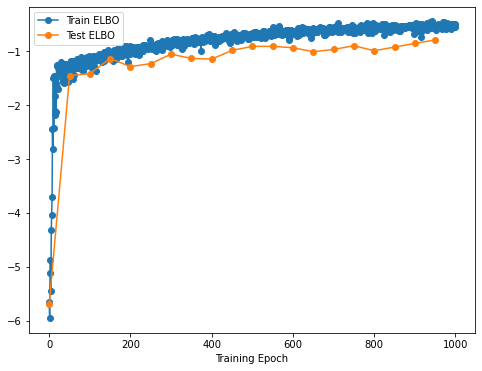

In [312]:
plot_llk(train_elbo, test_elbo, test_iter)

In [313]:
W, b = lr_model.guide_(X_train.float(), y_train.float())

<ipython-input-299-bef7a2779544>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w.append(torch.tensor(pyro.sample(
<ipython-input-299-bef7a2779544>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b.append(torch.tensor(pyro.sample(


(array([ 1.,  2.,  4., 11., 15., 14., 16., 16.,  8., 13.]),
 array([-2.84416019, -2.79101602, -2.73787185, -2.68472768, -2.63158351,
        -2.57843934, -2.52529517, -2.472151  , -2.41900683, -2.36586266,
        -2.31271849]),
 <a list of 10 Patch objects>)

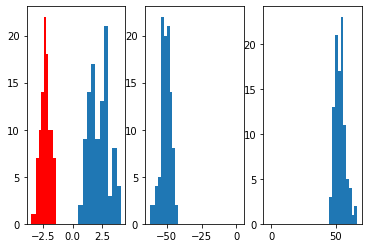

In [323]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].detach().numpy())
ax2.hist(Θ_1[:,1].detach().numpy())
ax3.hist(Θ_1[:,2].detach().numpy())


ax1.hist(b.detach().numpy(), color="red")
ax2.hist(W[:,0].detach().numpy(), color="red")
ax3.hist(W[:,1].detach().numpy(), color="red")


In [324]:
Θ_1

tensor([[  3.3981, -55.9595,  59.3626],
        [  1.8371, -55.8780,  59.1178],
        [  2.7925, -50.0974,  53.8550],
        [  1.5343, -46.5838,  49.2708],
        [  2.6799, -54.2140,  57.3831],
        [  3.5487, -49.8660,  53.2450],
        [  1.6985, -53.9561,  57.2794],
        [  2.8306, -48.1679,  51.1536],
        [  1.0807, -58.4377,  61.1965],
        [  1.6990, -50.5811,  53.6789],
        [  2.2678, -51.0029,  53.2882],
        [  1.6744, -44.7228,  48.7432],
        [  1.6803, -50.8084,  53.0059],
        [  2.3169, -48.4102,  51.6702],
        [  1.5201, -52.4942,  55.5914],
        [  2.5354, -41.9524,  45.2286],
        [  3.1206, -50.9975,  55.5756],
        [  1.6528, -51.3683,  54.4581],
        [  3.2940, -51.9834,  55.0708],
        [  1.4057, -56.9473,  61.0974],
        [  2.1271, -50.4414,  54.4912],
        [  3.4731, -47.9747,  51.4734],
        [  3.4381, -44.3239,  47.9220],
        [  2.0770, -52.6595,  55.8253],
        [  2.7811, -48.1465,  51.0208],
